# SkinAnaliticAI, Skin Cancer Detection with AI Deep Learning

## __Evaluation of Harvard Dataset with different AI classiffication techniques using FastClassAI papeline__
Author: __Pawel Rosikiewicz__   
prosikiewicz@gmail.com      
License: __MIT__    
ttps://opensource.org/licenses/MIT        
Copyright (C) 2021.01.30 Pawel Rosikiewicz        

## Goals:
* quick EDA on data provided by dataset Authors, 
* to prepare a summary table with filtered images (eg no missing data) with all metadata that could be used lateron, in in the project 
* if metadat are not available, you need to find following informaiton on each image:  
    * image names, 
    * original classs label for each image that will correspon dot orinal labels in config files, 

## Key Observations:
* __classed_to_poredict/target__
    * presented in dx column, 
    * 7 classes 
* __columns with dx_type__,   
    * indicates, how the images were classified, From documentarion we know that there were three methods:
    * histo - histopatological, using biopsy to classify the lession - considered most reliable (53.7% of images), 
    * followup - image 
* __missing data__ 
    * approximately 0.1% of rows have missing data  
    * these were found only in one column: age
* __duplicates__
    * all image_id are unique, 
    * howvever, many images are technical duplicates, ie, these are images of the same skin chnages (lesions), taken at different time, angle, magniffication etc.. 

## Caution
* all config files are based on original class labeling, 
* other labelling dictionaries were created to for example, merge different classes easily with each other, 
* if classes are not available, or are "weird", just select one classyficaiton system and then work with it, 
* class labels can be very easily changed, in that project

#### standard imports

In [ ]:
import os # allow changing, and navigating files and folders, 
import sys
import shutil
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# setup basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

# set up paths for the project
PATH_raw = os.path.join(basedir, "data/raw")
PATH_interim = os.path.join(basedir, "data/interim")
PATH_interim_dataset_summary_tables = os.path.join(PATH_interim, "dataset_summary_tables") # create in that notebook, 

# caution, loaded only form basedir,
import src.utils.EDA_Helpers2 as eda_helpers 
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.data_preparation_tools import copy_and_organize_files_for_keras_image_generators
from src.utils.data_preparation_tools import create_file_catalogue
from src.utils.data_preparation_tools import create_keras_comptatible_file_subset_with_class_folders
from src.utils.example_plots import *
from src.utils.feature_extraction_tools import encode_images_with_tfhubmodule # with tf.compat.v1 functions, for tf.__version___ >= 1.15
from src.utils.clustered_histogram import find_n_examples_in_each_class, clustered_histogram_with_image_examples, calculate_linkage_for_images_with_extracted_features
from src.utils.clustered_histogram import add_descriptive_notes_to_each_cluster_in_batch_labels, find_clusters_on_dendrogram, create_clustered_heatmap_with_img_examples
from src.utils.data_loaders import load_encoded_imgbatch_using_logfile, load_raw_img_batch
from src.utils.example_plots_after_clustering import plot_img_examples, create_spaces_between_img_clusters, plot_img_examples_from_dendrogram
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.data_preparation_tools import create_data_subsets

# load project configs
from src.configs.project_configs import PROJECT_NAME
from src.configs.project_configs import CLASS_DESCRIPTION # information on each class, including descriptive class name and diegnostic description - used to help wiht the project
from src.configs.tfhub_configs import TFHUB_MODELS # names of TF hub modules that I presenlected for featuress extraction with all relevant info,
from src.configs.dataset_configs import DATASET_CONFIGS # names created for clases, assigned to original one, and colors assigned to these classes
from src.configs.dataset_configs import CLASS_LABELS_CONFIGS # names created for clases, assigned to original one, and colors assigned to these classes
from src.configs.dataset_configs import DROPOUT_VALUE # str, special value to indicate samples to remoce in class labels

#### variables used to clean the data

In [3]:
PROJECT_NAME                      = "SkinAnaliticAI_Harvard_dataset_evaluation" # 
DATASET_NAME                      = "HAM10000"  # name used in config files to identify all info on that dataset variant

# metadata table cleaning 
ORIGINAL_METADATA_FILENAME        = "HAM10000_metadata.csv" # this is something you must check, I had only one csv file in that case
COLNAME_ORIGINAL_FILENAMES        = "image_id"
COLNAME_ORIGINAL_CLASS_LABELS     = "dx" # we will use original_labels column later on to have standard name
COLNAME_POTENTIAL_DUPLICATES      = ["lesion_id"] # each treated separately, 
COLNAME_ORGINAL_CLASS_TO_REDUCE   = {"nv":3000}  # ie. 2500 randomly selected images in nv class will be removed, 

#.. adding new info to metadata
DATA_TYPE                         = "raw_data"   # no image augmentation was applied, added to metadata o each raw image, 
DATASET_VARIANTS                  = DATASET_CONFIGS[DATASET_NAME]["labels"] # class labels that will be used, SORT_FILES_WITH   must be included

# sorting images into class-labelled folders, 
SORT_FILES_WITH                   = "original_labels" # these class labels will be used to sort images, the other classes will be stored 
INPUT_DATA_DIRNAME_LIST           = ["HAM10000_images_part_1", "HAM10000_images_part_2"] # name of files where are located raw files/images that will be ssegragated with one of the class labe systems
OUTPUT_DIRNAME                    = DATASET_NAME # dir name in basedir/intrim where sorted images will be stored, 

## Load anmd explore metadata, 
* join mutiple files into one df, if required

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


........................................,
 CAUTION,
 the file: none,
 THE FILE WAS NOT SAVED, 
 save_dir and/or csv_file_name were not provided  
 in: /Users/pawel/Desktop/Activities/100__Projects/SkinDiagnosticAI/data/raw 
........................................


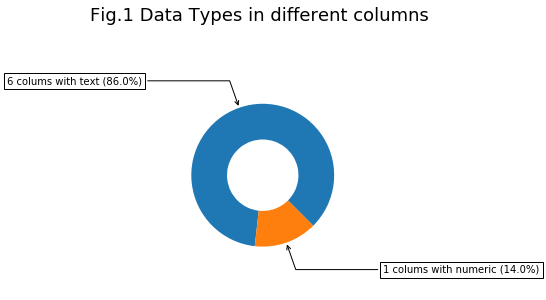

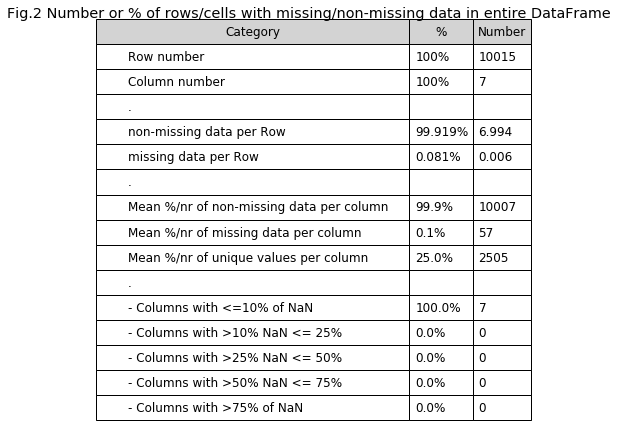

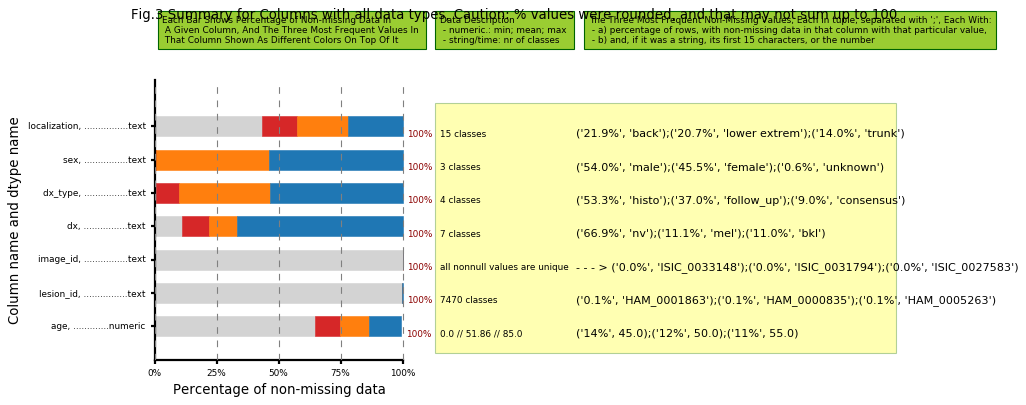

In [4]:
os.chdir(PATH_raw); 

# load metadata for images and check the df, 
img_metadata = pd.read_csv(ORIGINAL_METADATA_FILENAME)
display(img_metadata.head(5))
    
# summarize the table with DATA FRAME EXPLORER
data_examples, top_val_names, top_val_perc = eda_helpers.summarize_df(df=img_metadata) 
eda_helpers.examine_df_visually(data_examples = data_examples, top_values_perc = top_val_perc) 

## CLEAN THE IMAGE LABELS FROM MISSING DATA AND DUPLICATES, [BALANCE THE CLASSES]
* Remove duplicates and rows with missing data, 
* optionally, reduce the number of images in one unbalanced classes
* create or duplicatec column with one class_labels system names "original_class"
    * here i was using dsata form one source, so that was not an issue, but it becomes one, if you need to used data form many different sources, having different names for the same class

* The final table shodul have columns with:
    * original_filename - original, and unique file/image name
    * original_class - see in the above, 



In [7]:
# load-again original metadata 
'''
    re-loading, helps if you introduce some chnages in cleaning process, 
    but only if df is relatively small, otherwise make a copy here, 
    or develope cleaning procedure on a smaller subset
'''
os.chdir(PATH_raw);  
dataset_summary_table  = pd.read_csv(ORIGINAL_METADATA_FILENAME)


# .......................................................
# Global modiffication

# (a) find, or create columns with original_filename & original_labels, and name them like that, 
dataset_summary_table["original_filenames"]  = dataset_summary_table[COLNAME_ORIGINAL_FILENAMES]
dataset_summary_table["original_labels"]     = dataset_summary_table[COLNAME_ORIGINAL_CLASS_LABELS]

# (b) add columns with project metadata
dataset_summary_table["project_name"]       = PROJECT_NAME # no image augmentation was applied
dataset_summary_table["dataset_name"]       = DATASET_NAME
dataset_summary_table["data_type"]          = DATA_TYPE

# (c) keep raw data, to compare them with cleaned data, later on, 
dataset_summary_table_before_cleaning = dataset_summary_table.copy()
dataset_summary_table_before_cleaning["dataset_cleaing"] = "before_cleaning"



# .......................................................
# Remove rows with missing data, and duplicates,

# (a) remove rows with missing data
print("table shape - no chnages: ",dataset_summary_table.shape)
dataset_summary_table = dataset_summary_table.dropna(axis=0)
print("table shape - without na: ", dataset_summary_table.shape)

# (b) remove rows with duplicated image_ids
for one_colname in COLNAME_POTENTIAL_DUPLICATES:
    dataset_summary_table = dataset_summary_table.drop_duplicates(subset=one_colname, keep='first')
    dataset_summary_table.reset_index(inplace=True)
print("table shape - without duplicates: ", dataset_summary_table.shape)

# (c) again keep raw data, to compare them with cleaned data, later on, 
dataset_summary_table_without_NA_duplicates = dataset_summary_table.copy()
dataset_summary_table_without_NA_duplicates["dataset_cleaing"] = "NA_and_dupl_removed"



# .......................................................
# Balance the datset: remove random images form selected classes, 
''' here, for simplicity,  decided to provide numbers, instead of % values, '''

# (a) print info,
print("\nclass_counts before balancing")
display(dataset_summary_table.loc[:, COLNAME_ORIGINAL_CLASS_LABELS].value_counts())


# (b) remove requested number of images from selected classes
print("\n")
if len(COLNAME_ORGINAL_CLASS_TO_REDUCE)>0:
    for cl, nr in COLNAME_ORGINAL_CLASS_TO_REDUCE.items():
        print(f" - removing {nr} files from {cl}")
        idx_to_remove = np.random.choice(np.where(dataset_summary_table.loc[:, COLNAME_ORIGINAL_CLASS_LABELS]==cl)[0], nr, replace=False)
        dataset_summary_table = dataset_summary_table.drop(idx_to_remove, axis=0)
        dataset_summary_table.reset_index(drop=True, inplace=True)
        
# (c) add note on data cleanign status
dataset_summary_table["dataset_cleaing"] = "balanced_and_cleaned"
    
# (d) quickly test results, 
print("\nclass_counts after balancing")
display(dataset_summary_table.loc[:, COLNAME_ORIGINAL_CLASS_LABELS].value_counts())
display(dataset_summary_table.head(2))

table shape - no chnages:  (10015, 12)
table shape - without na:  (9958, 12)
table shape - without duplicates:  (7418, 13)

class_counts before balancing


nv       5361
bkl       718
mel       613
bcc       327
akiec     228
vasc       98
df         73
Name: dx, dtype: int64



 - removing 3000 files from nv

class_counts after balancing


nv       2361
bkl       718
mel       613
bcc       327
akiec     228
vasc       98
df         73
Name: dx, dtype: int64

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,original_filenames,original_labels,project_name,dataset_name,data_type,dataset_cleaing
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419,bkl,SkinAnaliticAI_Harvard_dataset_evaluation,HAM10000,raw_data,balanced_and_cleaned
1,2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769,bkl,SkinAnaliticAI_Harvard_dataset_evaluation,HAM10000,raw_data,balanced_and_cleaned


In [8]:
# Save summary tables, 
PATH_results = os.path.join(PATH_interim, f'dataset_summary_tables')
try:
    os.mkdir(PATH_results)
except:
    pass
os.chdir(PATH_results)

# raw data, without NA and duplicates 
file_name = f"{DATASET_NAME}_cleaned__dataset_summary_table.csv"
dataset_summary_table_without_NA_duplicates.to_csv(file_name, header=True, index=False)
print("saved: ",file_name, " - shape ", dataset_summary_table_without_NA_duplicates.shape)

# cleaned data 
file_name = f"{DATASET_NAME}_cleaned_and_balanced__dataset_summary_table.csv"
dataset_summary_table.to_csv(file_name, header=True, index=False)
print("saved: ",file_name, " - shape ", dataset_summary_table.shape)

saved:  HAM10000_cleaned__dataset_summary_table.csv  - shape  (7418, 14)
saved:  HAM10000_cleaned_and_balanced__dataset_summary_table.csv  - shape  (4418, 14)


## Test How Data Cleaning affected each data varinat compositions with images/files in different classes

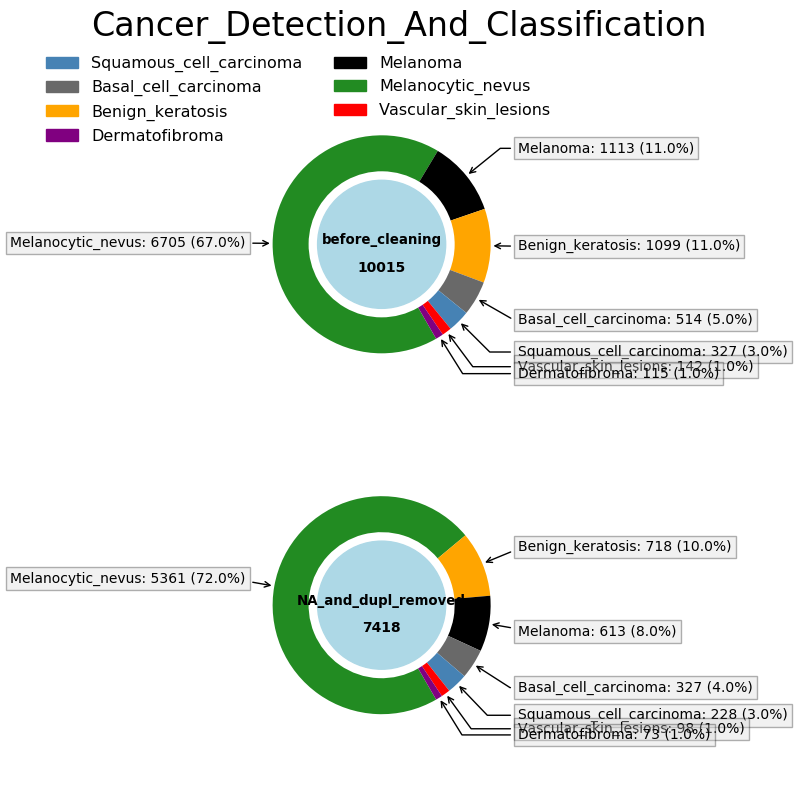

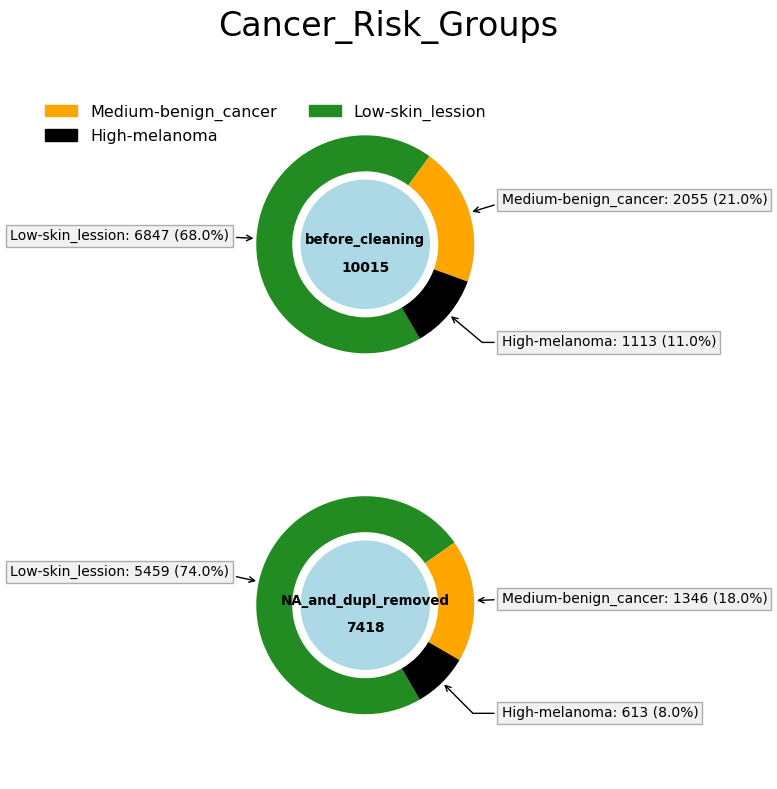

In [9]:
# prepare plot_data
'''
    concatenated df's need to have different values in dataset_cleaing column
    this will also include droppped out files/images (if any included), 
    that are removed, later-on, optionally while training a model,
'''
plot_data = pd.concat([dataset_summary_table_before_cleaning, 
                       dataset_summary_table_without_NA_duplicates],axis=0)


    
# plot pie charts with number of images in each class, in each classyficaiton system
for one_dataset_variant in DATASET_VARIANTS:
    
    # Prepare the data, and add them to df, 
    
    #.. map new class names on original labels
    ds_mapped_classnames = plot_data.loc[:, COLNAME_ORIGINAL_CLASS_LABELS].map(CLASS_LABELS_CONFIGS[one_dataset_variant]['class_labels_dict'])
    
    #..  add new columns to df, 
    plot_data[f"{one_dataset_variant}"] = ds_mapped_classnames
    
        
    # Pie chart with dataset composition
    annotated_pie_chart_with_class_and_group(
        title          = f'{one_dataset_variant}',
        classnames     = plot_data.loc[:, one_dataset_variant].values.tolist(),
        class_colors   = CLASS_LABELS_CONFIGS[one_dataset_variant]['class_labels_colors'],
        groupnames     = plot_data.dataset_cleaing.values.tolist(),
        # plot aestetics 
        figsze_scale=1.5,
        ax_title_fonsize_scale=0.6,
        wedges_fontsize_scale=1,
        add_group_item_perc_to_numbers_in_each_pie=False,
        title_ha="center",
        mid_pie_circle_color="lightblue",
        tight_lyout=True,
        subplots_adjust_top=0.9,
        legend_fontsize_scale=1.5,
        legend_loc=(0.05, 0.81),
        legend=True, # because each class is annotated, 
        legend_ncol=2,
        n_subplots_in_row=1
    )    

# STEP 3. CREATE DATSET WITH IMAGES/FILES SORTED INTO CLASS-NAMED FOLDERS
* __IMPORTANT__
    * I will crerate dataset folder in basedir/data/interim
    * there will be at least three folders, test, valid and train datasubsets
    * each folder may be divided into smaller subset, and they may or may not be called as train/valid

In [14]:
# Load dataset summary table with all images that will be used
os.chdir(PATH_interim_dataset_summary_tables)
file_name             = f"{DATASET_NAME}_cleaned__dataset_summary_table.csv"
dataset_summary_table = pd.read_csv(file_name)
dataset_summary_table.reset_index(drop=True, inplace=True)

## STEP 3a) Create dataset variant with class-sorted images

In [15]:
## STEP 3a) CREATE FOLDER FOR EACH DATASET VARIANT, WITH SORTED IMAGES
for dt_i, dataset_variant in enumerate(DATASET_VARIANTS):
    print(f'- {dt_i} - Preparing: {dataset_variant}')

    # exctract filenames and original class labels, 
    original_filenames      = pd.Series(dataset_summary_table.loc[:, "original_filenames"])
    original_labels         = pd.Series(dataset_summary_table.loc[:, "original_labels"])
     
    # Find class labels for dataset variant   
    class_labels_variant_dict = CLASS_LABELS_CONFIGS[dataset_variant]["class_labels_dict"]
    new_class_labels = original_labels.map(class_labels_variant_dict)
    
    # Remove dropout class or files, 
    '''here you may add the code, to remove speciffic files/images'''
    idx_to_remove      = np.where(new_class_labels==DROPOUT_VALUE)[0].tolist()
    new_class_labels   = new_class_labels.drop(idx_to_remove).values.tolist()
    original_filenames = original_filenames.drop(idx_to_remove).values.tolist()    
    
    # copy files to temporary directory and organize with new class labels
    _, _ =  copy_and_organize_files_for_keras_image_generators(
            # ... files description
            file_name_list          = original_filenames,   # list, names of files to be copied, if they contain file extension, see ad d nothing below, 
            class_name_list         = new_class_labels,     # list of classses, same lenght as file_names_list, Caution, no special characters allowed !
            # ... inputs
            src_path                = PATH_raw,                 # str, path to file, that holds at least one, specified folder with files (eg images.jpg) to copy, to  data_dst_path/class_name/files eg .jpg
            src_dataset_name_list   = INPUT_DATA_DIRNAME_LIST,  # names of directories, that shodul be found in input_data_path
            # ... outputs
            dst_path                = PATH_interim,        # str, path to file, where the new_dataset file will be created, as follow data_dst_path/dataset_name/subset_name/class_name/files eg .jpg
            dst_dataset_name        = f"{DATASET_NAME}__{dataset_variant}",  # str, used to save the file, in data_dst_path/dataset_name/subset_name/class_name/files eg .jpg
            dst_subset_name         = "All_files_organized_by_class",    # str, same as above, eg=train data, data_dst_path/dataset_name/subset_name/class_name/files eg .jpg
            file_extension_list     = [".jpg"],            # file extensions that shoudl be tranferred, dont forget about the dot., the fucntion will also accept "" as for no extension
            # ...
            verbose=False,
            track_progres=False,  
            return_logfiles=True,                   # returns, list with 
            create_only_logfiles=False              # bool, special option, the function bechaves in the same way, except it do not copy files, but create logfiles only,
                                                    #        with classified, items, grouped in dct where key is a class name, it rtunrs two logfiles, with present and mising files,
        ) 

    # test if the images were copied as expected
    _ = create_file_catalogue(
            path = os.path.join(PATH_interim, 
                                f"{DATASET_NAME}__{dataset_variant}",
                                "All_files_organized_by_class"
                               ),
            searched_class_name_list = None, # if none, catalog, all, 
            verbose=True)
    print(f"\n")

- 0 - Preparing: Cancer_Detection_And_Classification
Basal_cell_carcinoma: 327
Squamous_cell_carcinoma: 228
Melanoma: 613
Melanocytic_nevus: 5361
Benign_keratosis: 718
Vascular_skin_lesions: 98
Dermatofibroma: 73


- 1 - Preparing: Cancer_Risk_Groups
High-melanoma: 613
Medium-benign_cancer: 1346
Low-skin_lession: 5459




## STEP 3c) CREATE TRAIN, TEST AND VALIDATION DATASET SUBSETS IN EACH DATASET VARIANT
* each of them will have 10% of images, with the same proportions of images in each class as in the source
* All_files_organized_by_class folder shodul be empty at the end, 
* IMPORTANT: I'am moving images, instead of copying them, to avoid creating duplicates between subsets

In [16]:
for dt_i, dataset_variant in enumerate(DATASET_VARIANTS):
    print(f'- {dt_i} - Preparing subsets for {dataset_variant}')

    # names,
    src_path                 = os.path.join(PATH_interim, f'{DATASET_NAME}__{dataset_variant}')
    src_subset_name          = f"All_files_organized_by_class"
    dst_path                 = src_path
    new_data_subset_names    = [    'test_01', 'test_02',
                                    'valid_01', "valid_02", 
                                    "train_01", "train_02","train_03", 
                                     "train_04","train_05", "train_06","train_07"]
    file_proportions         = [0.05,0.05]+[0.1]*8+[0.99] # the last one is larger to ensure that all files will be tranferred and none left due to rounding errors,                  
        
    # create subsets with equal proportins of images from each class
    create_data_subsets(
                src_path                 = src_path,
                src_subset_name          = src_subset_name,
                dst_path                 = dst_path,
                dst_subset_name_list     = new_data_subset_names,
                # ...
                new_subset_size          = file_proportions, # list, ==len(dst_subset_name_list)
                min_new_subset_size      = 0.025,
                # ...
                move_files               = True,
                random_state_nr          = 0,
                fix_random_nr            = True,
                verbose                  = False
            )            
    print("done ........................ no more files to transfer\n")

- 0 - Preparing subsets for Cancer_Detection_And_Classification
Found 7418 images belonging to 7 classes.
Found 7051 images belonging to 7 classes.
Found 6684 images belonging to 7 classes.
Found 5944 images belonging to 7 classes.
Found 5203 images belonging to 7 classes.
Found 4461 images belonging to 7 classes.
Found 3719 images belonging to 7 classes.
Found 2977 images belonging to 7 classes.
Found 2233 images belonging to 7 classes.
Found 1489 images belonging to 7 classes.
Found 751 images belonging to 7 classes.
done ........................ no more files to transfer

- 1 - Preparing subsets for Cancer_Risk_Groups
Found 7418 images belonging to 3 classes.
Found 7049 images belonging to 3 classes.
Found 6679 images belonging to 3 classes.
Found 5938 images belonging to 3 classes.
Found 5197 images belonging to 3 classes.
Found 4456 images belonging to 3 classes.
Found 3714 images belonging to 3 classes.
Found 2972 images belonging to 3 classes.
Found 2229 images belonging to 3 cl

## Check how many images and from what class were placed in each subset in each dtataset variant

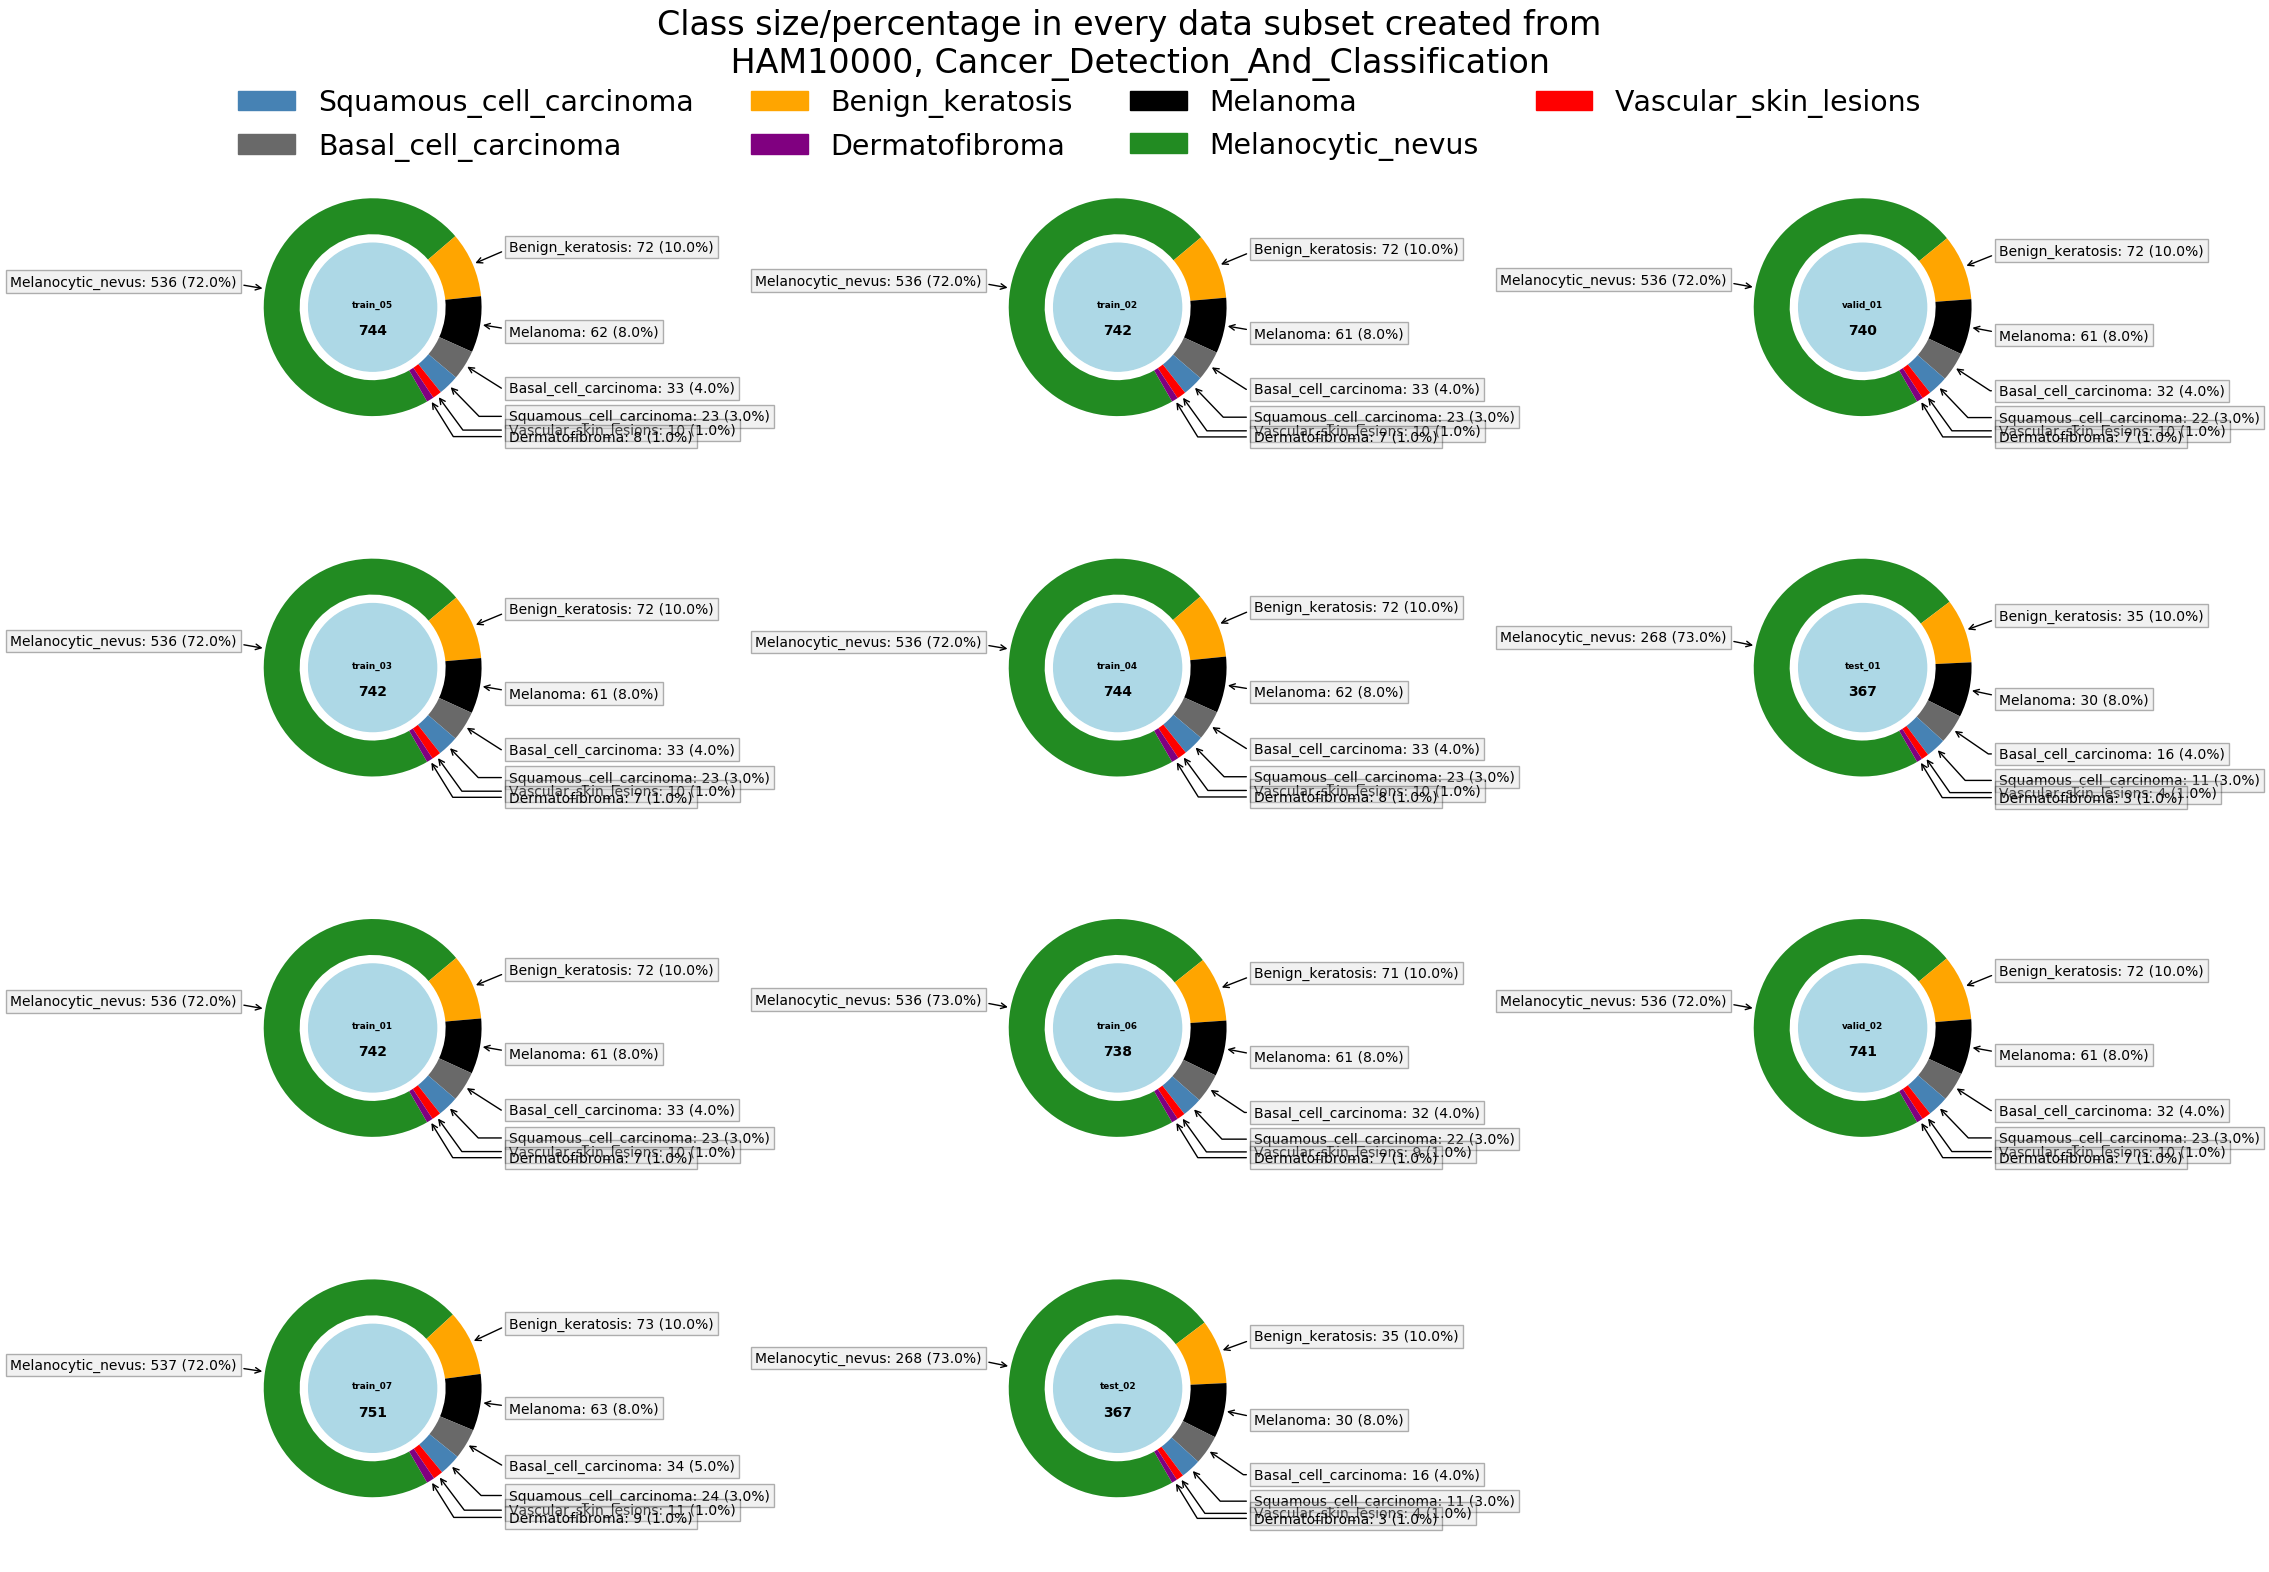

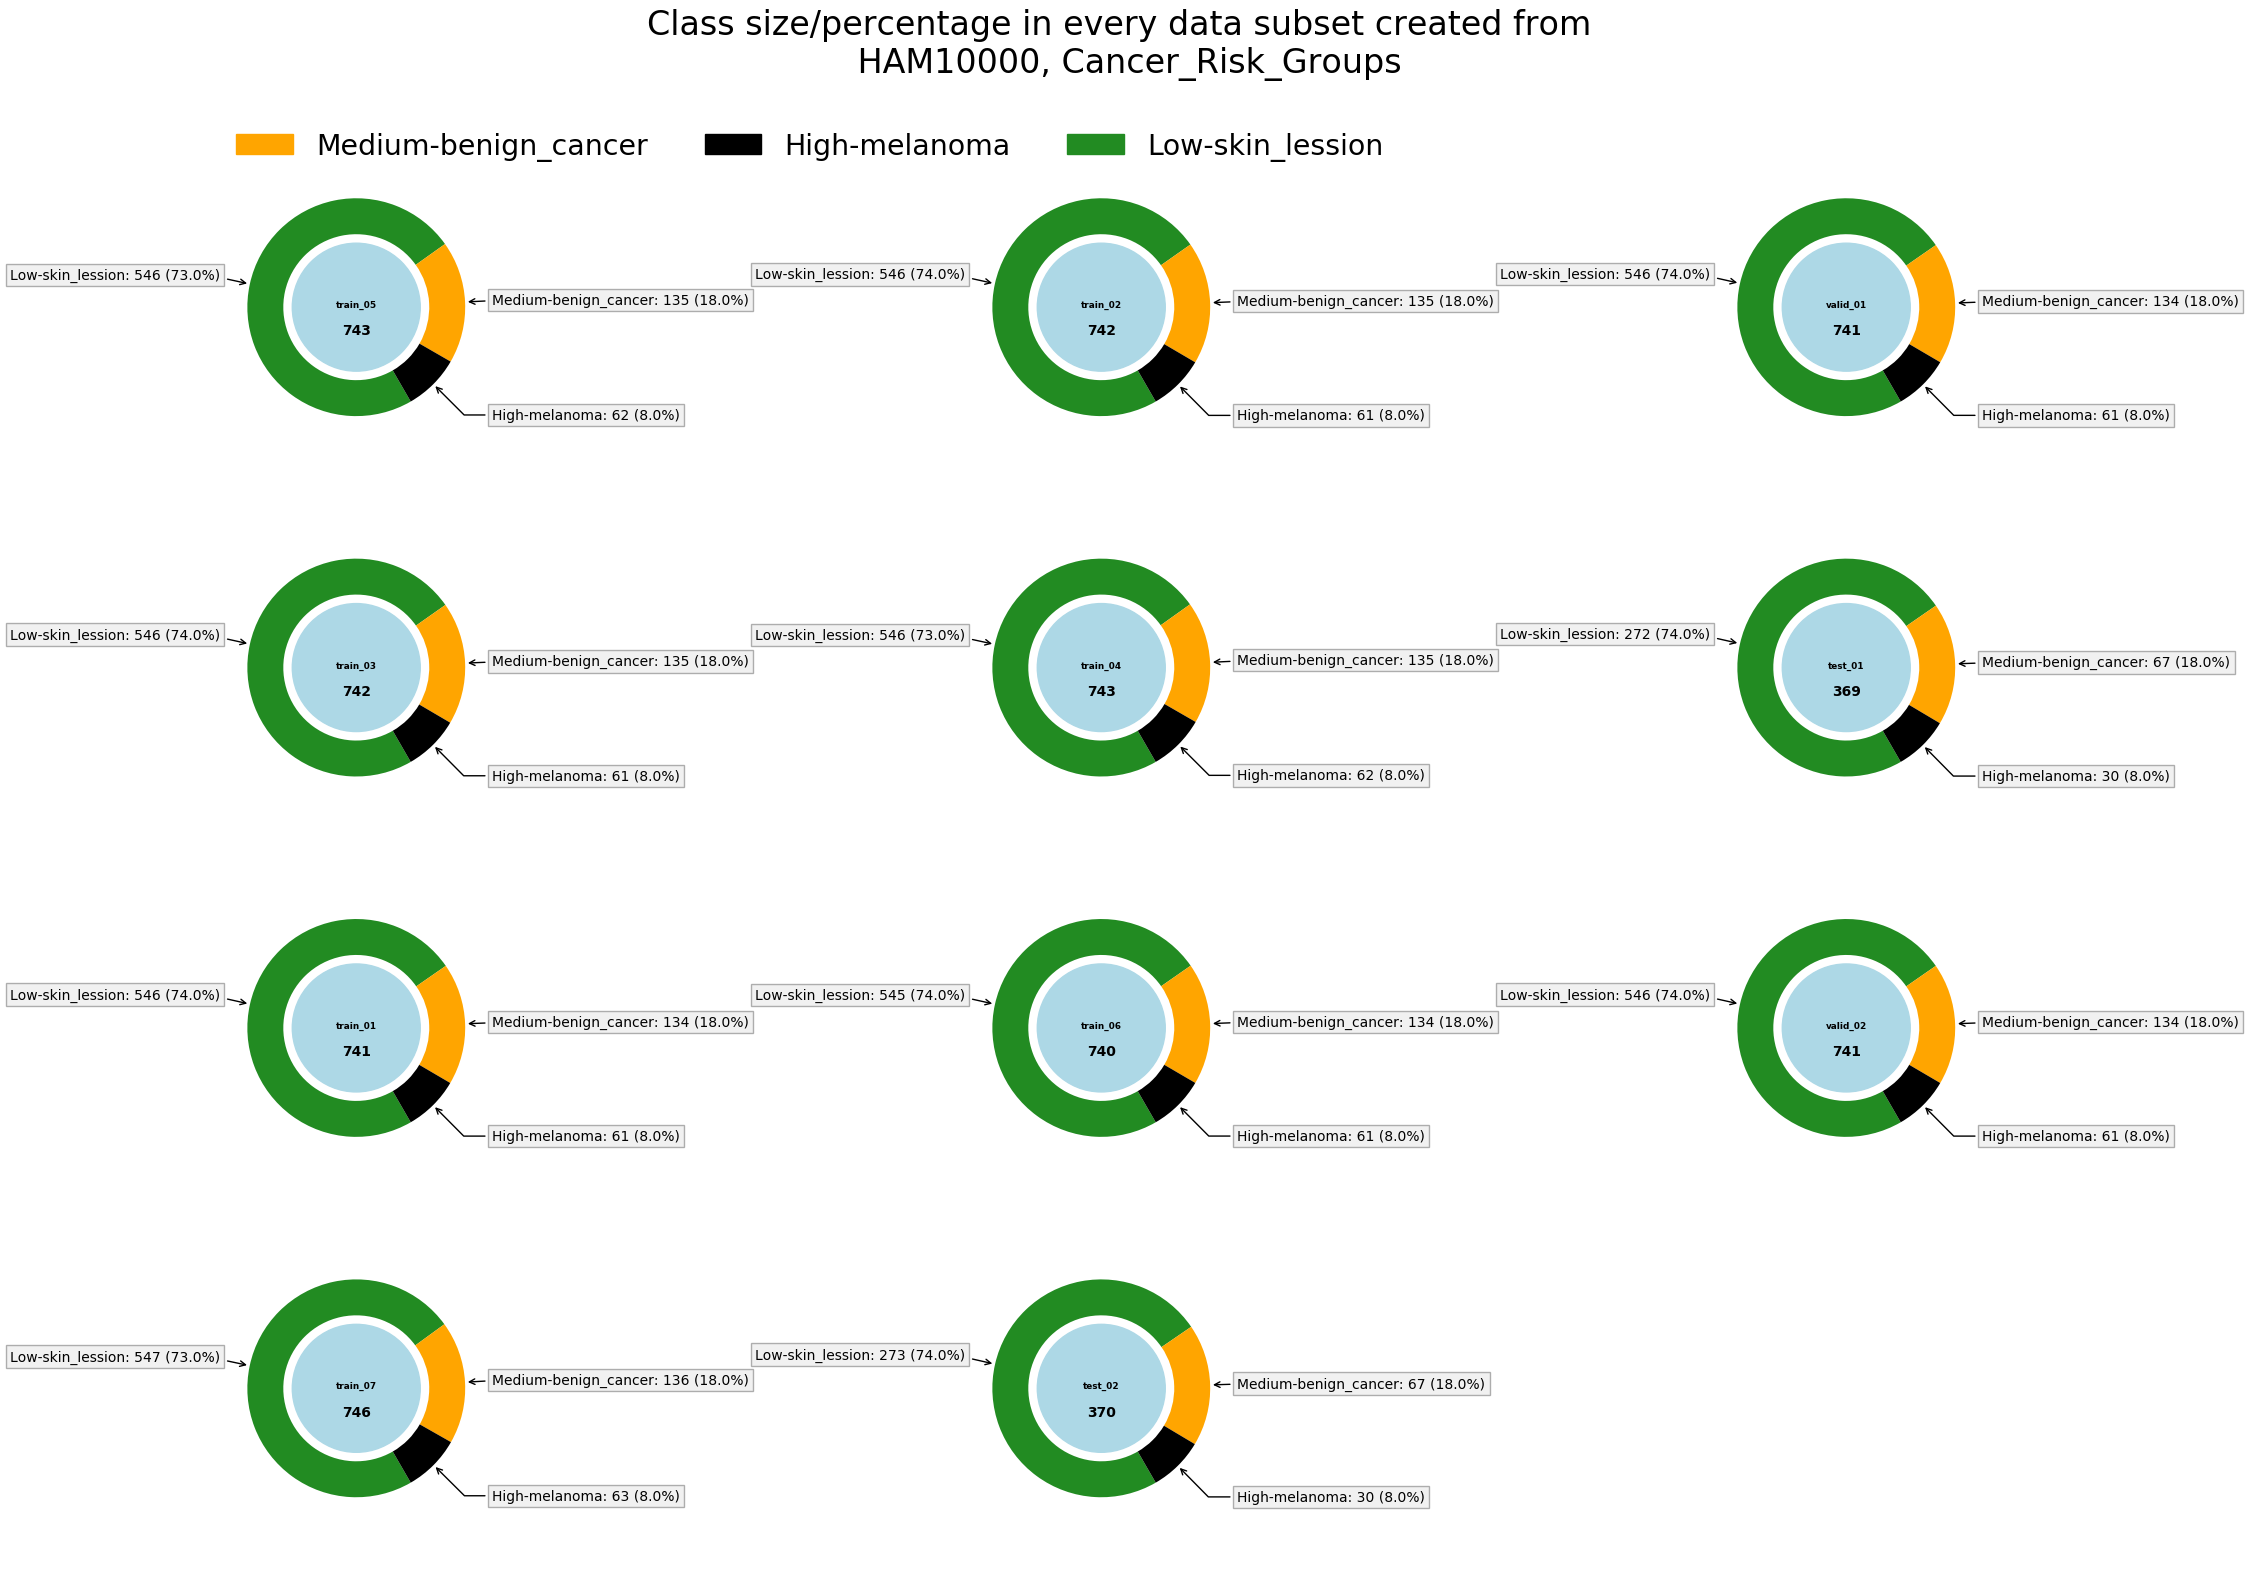

In [17]:
# find all newly created folders wiht subsets in dataset folder, 
for dataset_variant in DATASET_VARIANTS:
    path = os.path.join(PATH_interim, f"{DATASET_NAME}__{dataset_variant}")
    os.chdir(path)
    
    filenames = []
    class_long_list = list()
    file_long_list = list()
    for file in glob.glob(f"[test|valid|train]*"):
        filenames.append(file)    
    
    for s_name in filenames:
        log = create_file_catalogue(
                path = os.path.join(path, s_name),
                searched_class_name_list = None, # if none, catalog, all, 
                verbose=False)
        
        for one_key in list(log.keys()):
            class_long_list.extend([one_key]*len(log[one_key]))
            file_long_list.extend([s_name]*len(log[one_key]))

    # .. Pie chart with dataset composition
    annotated_pie_chart_with_class_and_group(
        title=f'Class size/percentage in every data subset created from \n {DATASET_NAME}, {dataset_variant}',
        classnames=class_long_list,
        groupnames=file_long_list,
        class_colors=CLASS_LABELS_CONFIGS[dataset_variant]["class_labels_colors"], 
        figsze_scale=1.5,
        ax_title_fonsize_scale=0.4,
        wedges_fontsize_scale=1,
        add_group_item_perc_to_numbers_in_each_pie=False,

        title_ha="center",
        mid_pie_circle_color="lightblue",
        tight_lyout=True,
        subplots_adjust_top=0.9,
        legend_loc=(0.1, 0.89),
        legend=True, # because each class is annotated, 
        legend_ncol=4,
        legend_fontsize_scale=4,

        n_subplots_in_row=3
    )

## Show examples of images from different clasees form different subsets in each dataset variant 


 - Cancer_Detection_And_Classification - 

Found 744 images belonging to 7 classes.
train_05, Classes: ['Basal_cell_carcinoma', 'Benign_keratosis', 'Dermatofibroma', 'Melanocytic_nevus', 'Melanoma', 'Squamous_cell_carcinoma', 'Vascular_skin_lesions']


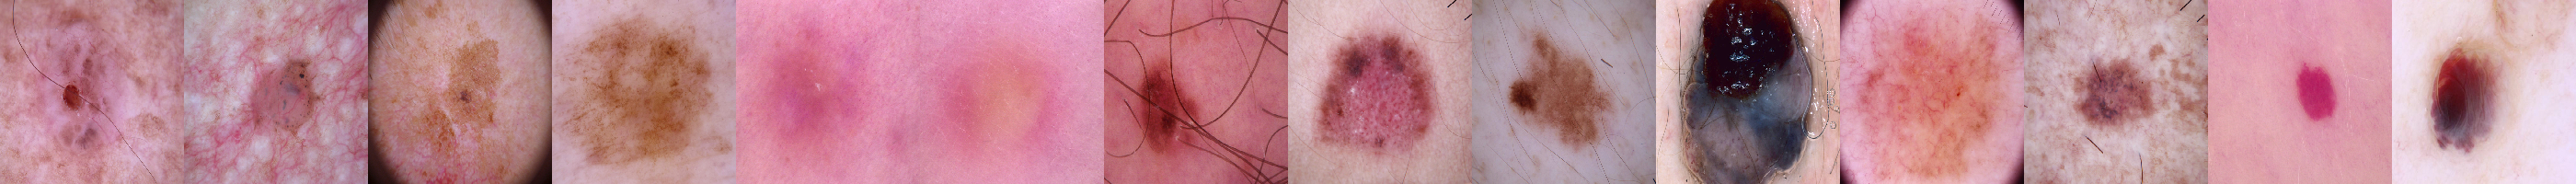


 - Cancer_Risk_Groups - 

Found 743 images belonging to 3 classes.
train_05, Classes: ['High-melanoma', 'Low-skin_lession', 'Medium-benign_cancer']


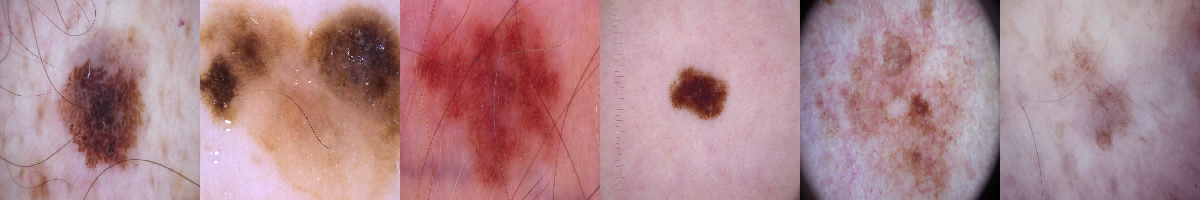

In [18]:
# find all newly created folders wiht subsets in dataset folder, 
for dataset_variant in DATASET_VARIANTS:
    print(f"\n - {dataset_variant} - \n")
    path = os.path.join(PATH_interim, f"{DATASET_NAME}__{dataset_variant}")
    os.chdir(path)
    
    # find filenames with images
    filenames = []
    for file in glob.glob(f"[test|valid|train]*"):
        filenames.append(file)   
        
    # reduce number if dataset to display (too much space)
    filenames = filenames[0:1]    
         
    # create data generator with batch size for up to 1000 randomly selceted images
    datagen = ImageDataGenerator()#rescale=1/255) 
    dataiter_dict = dict()
    for sn in filenames:
        # .. create proper iterator, that allowss loading all availble images, - here it will always load all files, 
        dataiter_dict[sn]  = datagen.flow_from_directory(
                            os.path.join(path, sn), 
                            target_size=(200, 200),
                            batch_size=200, #img_nr_in_one_subset, 
                            shuffle=True # done later on by my fucntion        
        )    


    # Plot two examples of each class from each dataset, 
    for setname in filenames:
        display(plot_example_images_using_generator(
            dataiter_dict[setname],
            title=setname, 
            pixel_size=200, # only one value, as both heigh and width will be the same
            class_n_examples=2)
               )